In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from shapely.geometry import Polygon
from sklearn.metrics import ConfusionMatrixDisplay

## Read and Prase GT Annotations & Model Predictions

### GT Annotations from Json File

In [2]:
# read GT json file
fname = "ground-truth-coco/annotations.json"
with open(fname, "r") as f:
    data = json.load(f)

# Check keys of GT json file
for k in data.keys():
    print(f"key: {k}\n\tLength: {len(data[k])}")

key: images
	Length: 10
key: categories
	Length: 2
key: annotations
	Length: 369


In [3]:
# convert to pandas dataframes
categories = pd.DataFrame(data["categories"])
images = pd.DataFrame(data["images"])
annotations = pd.DataFrame(data["annotations"])

In [4]:
categories

,supercategory,id,name
0,,1,box
1,,2,wall


In [5]:
images

,height,width,id,file_name
0,800,1280,1,20231005162441_im_bottom.png
1,720,1280,2,20230919162848_im_bottom.png
2,720,1280,3,09282023170518_top_image.png
3,720,1280,4,20230927175330_im_bottom.png
4,720,1280,5,09292023095618_bottom_image.png
5,720,1280,6,20231003152513_im_top.png
6,800,1280,7,10162023085620_bottom_image.png
7,720,1280,8,20230913091200.png
8,720,1280,9,20231003152902_im_top.png
9,800,1280,10,20231005162807_im_top.png


In [6]:
annotations

,segmentation,iscrowd,image_id,bbox,area,category_id,id
0,"[[787, 317, 851, 315, 839, 366, 776, 372]]",0,1,"[776.0, 315.0, 76.0, 57.0]",4332.0,1,1
1,"[[715, 322, 707, 379, 774, 373, 785, 319]]",0,1,"[706.0, 319.0, 79.0, 60.0]",4740.0,1,2
2,"[[640, 326, 638, 385, 705, 379, 714, 323]]",0,1,"[637.0, 323.0, 77.0, 62.0]",4774.0,1,3
3,"[[563, 332, 566, 392, 637, 385, 639, 326]]",0,1,"[563.0, 326.0, 76.0, 66.0]",5016.0,1,4
4,"[[484, 340, 492, 397, 566, 392, 562, 333]]",0,1,"[484.0, 333.0, 82.0, 64.0]",5248.0,1,5
...,...,...,...,...,...,...,...
364,"[[723, 262, 800, 269, 794, 347, 718, 343]]",0,10,"[718.0, 262.0, 82.0, 85.0]",6970.0,1,365
365,"[[802, 265, 872, 271, 866, 346, 796, 343]]",0,10,"[796.0, 265.0, 76.0, 81.0]",6156.0,1,366
366,"[[796, 343, 866, 347, 860, 422, 789, 420]]",0,10,"[789.0, 343.0, 77.0, 79.0]",6083.0,1,367
367,"[[140, 798, 362, 800, 363, 776, 356, 701, 350,...",0,10,"[2.0, 0.0, 1277.0, 799.0]",1020323.0,2,368


In [7]:
# add images dataframe to annotations dataframe
annotations = pd.merge(annotations, images[["id", "height", "width", "file_name"]], left_on="image_id", right_on="id")
annotations = annotations.drop(columns=["id_x", "id_y"]) # drop index columns
annotations

,segmentation,iscrowd,image_id,bbox,area,category_id,height,width,file_name
0,"[[787, 317, 851, 315, 839, 366, 776, 372]]",0,1,"[776.0, 315.0, 76.0, 57.0]",4332.0,1,800,1280,20231005162441_im_bottom.png
1,"[[715, 322, 707, 379, 774, 373, 785, 319]]",0,1,"[706.0, 319.0, 79.0, 60.0]",4740.0,1,800,1280,20231005162441_im_bottom.png
2,"[[640, 326, 638, 385, 705, 379, 714, 323]]",0,1,"[637.0, 323.0, 77.0, 62.0]",4774.0,1,800,1280,20231005162441_im_bottom.png
3,"[[563, 332, 566, 392, 637, 385, 639, 326]]",0,1,"[563.0, 326.0, 76.0, 66.0]",5016.0,1,800,1280,20231005162441_im_bottom.png
4,"[[484, 340, 492, 397, 566, 392, 562, 333]]",0,1,"[484.0, 333.0, 82.0, 64.0]",5248.0,1,800,1280,20231005162441_im_bottom.png
...,...,...,...,...,...,...,...,...,...
364,"[[723, 262, 800, 269, 794, 347, 718, 343]]",0,10,"[718.0, 262.0, 82.0, 85.0]",6970.0,1,800,1280,20231005162807_im_top.png
365,"[[802, 265, 872, 271, 866, 346, 796, 343]]",0,10,"[796.0, 265.0, 76.0, 81.0]",6156.0,1,800,1280,20231005162807_im_top.png
366,"[[796, 343, 866, 347, 860, 422, 789, 420]]",0,10,"[789.0, 343.0, 77.0, 79.0]",6083.0,1,800,1280,20231005162807_im_top.png
367,"[[140, 798, 362, 800, 363, 776, 356, 701, 350,...",0,10,"[2.0, 0.0, 1277.0, 799.0]",1020323.0,2,800,1280,20231005162807_im_top.png


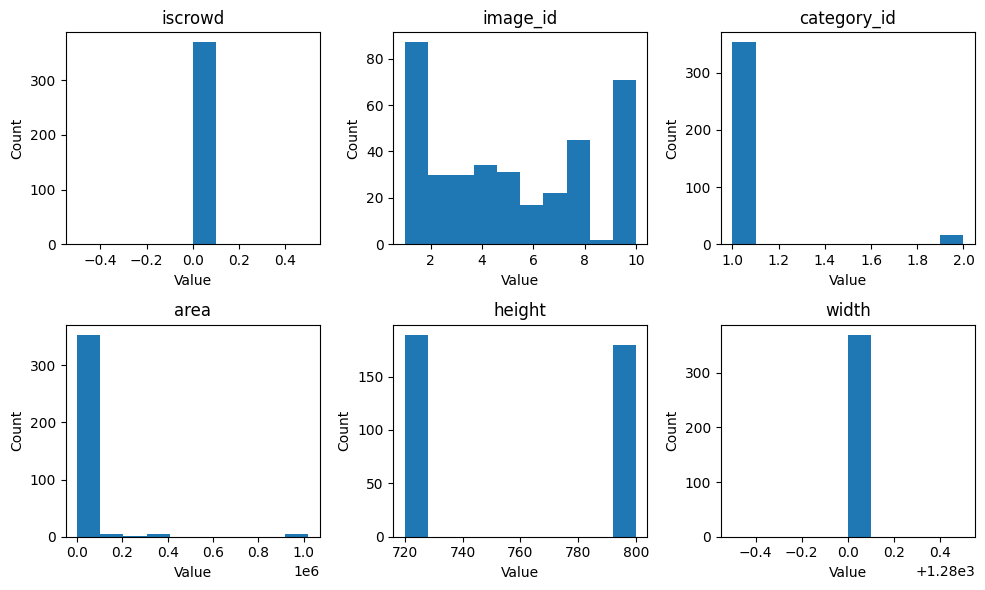

In [8]:
# visualize each header's distribution
hoi = ["iscrowd", "image_id", "category_id", "area", "height", "width"] # headers of interest
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for head in annotations.columns:
    if head in hoi:
        # plot
        ax = axs.flatten()[hoi.index(head)]
        ax.hist(annotations[head])
        ax.set_title(head)
        ax.set_xlabel("Value")
        ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

### Model Predictions (predicted from Mask R-CNN) from Json Files

In [9]:
pred_dir = "predictions" # parent directory of predictions
image_names = os.listdir(pred_dir) # subdirectories (image file names) of predictions

# full directory of outputs.json files
outputs_dir = [os.path.join(pred_dir, image_names, "outputs.json") for image_names in image_names]
print(outputs_dir)

# full directory of masks.npy files
masks_dir = [os.path.join(pred_dir, image_names, "masks.npy") for image_names in image_names]
print(masks_dir)

['predictions/20230913091200.png/outputs.json', 'predictions/20231005162807_im_top.png/outputs.json', 'predictions/20231005162441_im_bottom.png/outputs.json', 'predictions/10162023085620_bottom_image.png/outputs.json', 'predictions/09292023095618_bottom_image.png/outputs.json', 'predictions/20231003152513_im_top.png/outputs.json', 'predictions/09282023170518_top_image.png/outputs.json', 'predictions/20231003152902_im_top.png/outputs.json', 'predictions/20230927175330_im_bottom.png/outputs.json', 'predictions/20230919162848_im_bottom.png/outputs.json']
['predictions/20230913091200.png/masks.npy', 'predictions/20231005162807_im_top.png/masks.npy', 'predictions/20231005162441_im_bottom.png/masks.npy', 'predictions/10162023085620_bottom_image.png/masks.npy', 'predictions/09292023095618_bottom_image.png/masks.npy', 'predictions/20231003152513_im_top.png/masks.npy', 'predictions/09282023170518_top_image.png/masks.npy', 'predictions/20231003152902_im_top.png/masks.npy', 'predictions/202309271

In [10]:
# image file names
image_names

['20230913091200.png',
 '20231005162807_im_top.png',
 '20231005162441_im_bottom.png',
 '10162023085620_bottom_image.png',
 '09292023095618_bottom_image.png',
 '20231003152513_im_top.png',
 '09282023170518_top_image.png',
 '20231003152902_im_top.png',
 '20230927175330_im_bottom.png',
 '20230919162848_im_bottom.png']

In [11]:
# make a single dataframe for all outputs in the order of image file names
outputs = pd.DataFrame()
for i, output_dir in enumerate(outputs_dir):
    with open(output_dir, "r") as f:
        output = json.load(f)
    output = pd.DataFrame(output)
    output["file_name"] = image_names[i]
    outputs = pd.concat([outputs, output], axis=0)
outputs

,pred_boxes,scores,pred_classes,file_name
0,"[294.8004150390625, 20.53921890258789, 514.521...",0.998854,0,20230913091200.png
1,"[1021.9891967773438, 5.685061931610107, 1204.7...",0.998566,0,20230913091200.png
2,"[918.9055786132812, 195.64080810546875, 1161.9...",0.998526,0,20230913091200.png
3,"[542.7807006835938, 367.9463195800781, 680.674...",0.998431,0,20230913091200.png
4,"[900.0274047851562, 280.83349609375, 1120.3265...",0.998278,0,20230913091200.png
...,...,...,...,...
25,"[516.8760986328125, 494.85601806640625, 613.80...",0.996180,0,20230919162848_im_bottom.png
26,"[989.76953125, 268.4290466308594, 1107.5947265...",0.994859,0,20230919162848_im_bottom.png
27,"[32.759342193603516, 0.0, 1261.6337890625, 720.0]",0.992643,1,20230919162848_im_bottom.png
28,"[436.8408508300781, 493.9764099121094, 525.412...",0.981217,0,20230919162848_im_bottom.png


In [12]:
# make a single dataframe for all masks in the order of image file names, use torch tensor to save memory
masks = []
for i, mask_dir in enumerate(masks_dir):
    mask = torch.tensor(np.load(mask_dir))
    image_file_name = mask_dir.split("/")[1]
    mask = (mask, image_file_name) # tuple (mask, image file name)
    masks.append(mask)

# print image file names and corresponding masks' shapes
print()
for (mask, image_file_name) in masks:
    print(f"{image_file_name}\n\t{mask.shape}")


20230913091200.png
	torch.Size([41, 720, 1280])
20231005162807_im_top.png
	torch.Size([71, 800, 1280])
20231005162441_im_bottom.png
	torch.Size([84, 800, 1280])
10162023085620_bottom_image.png
	torch.Size([22, 800, 1280])
09292023095618_bottom_image.png
	torch.Size([32, 720, 1280])
20231003152513_im_top.png
	torch.Size([15, 720, 1280])
09282023170518_top_image.png
	torch.Size([30, 720, 1280])
20231003152902_im_top.png
	torch.Size([2, 720, 1280])
20230927175330_im_bottom.png
	torch.Size([34, 720, 1280])
20230919162848_im_bottom.png
	torch.Size([30, 720, 1280])


In [48]:
# check the number of bounding boxes for each image in GT
annotations_count = annotations["file_name"].value_counts()
print(f"GT:\n{annotations_count}")
print(f"Total: {annotations_count.sum()}")

# check the number of bounding boxes for each image in predictions
outputs_count = outputs["file_name"].value_counts()
print(f"\nPredicted Outputs:\n{outputs_count}")
print(f"Total: {outputs_count.sum()}")

GT:
file_name
20231005162441_im_bottom.png       87
20231005162807_im_top.png          71
20230913091200.png                 45
20230927175330_im_bottom.png       34
09292023095618_bottom_image.png    31
20230919162848_im_bottom.png       30
09282023170518_top_image.png       30
10162023085620_bottom_image.png    22
20231003152513_im_top.png          17
20231003152902_im_top.png           2
Name: count, dtype: int64
Total: 369

Predicted Outputs:
file_name
20231005162441_im_bottom.png       84
20231005162807_im_top.png          71
20230913091200.png                 41
20230927175330_im_bottom.png       34
09292023095618_bottom_image.png    32
09282023170518_top_image.png       30
20230919162848_im_bottom.png       30
10162023085620_bottom_image.png    22
20231003152513_im_top.png          15
20231003152902_im_top.png           2
Name: count, dtype: int64
Total: 361


## Mask IOU

### Sample

Image: 20231003152902_im_top.png
Height: 720
Width: 1280
x: [334, 553, 581, 581, 357, 294, 334]
y: [629, 600, 703, 718, 718, 718, 629]


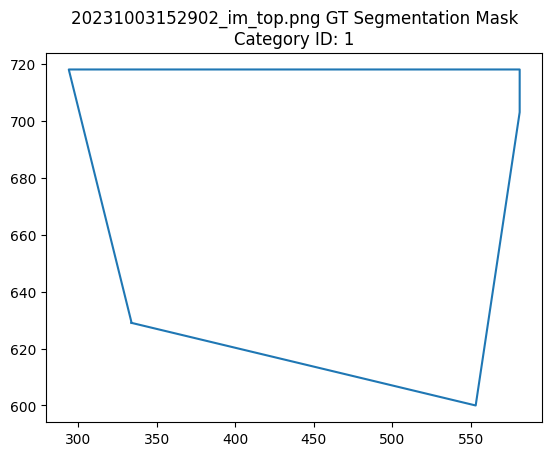

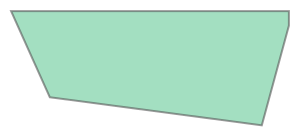

In [14]:
# visualize a sample of GT segmentation mask
idx = 296

# image file name of the sample mask
name_sample = annotations["file_name"][idx]

# category (class) ID of the sample mask
category_id = annotations["category_id"][idx]

# height and width of the image where the sample mask is from
h_sample, w_sample = annotations["height"][idx], annotations["width"][idx]
print(f"Image: {name_sample}\nHeight: {h_sample}\nWidth: {w_sample}")

# sample GT segmentation mask
gt_seg = annotations["segmentation"]
gt_sample = gt_seg[idx] # e.g., [[787, 317, 851, 315, 839, 366, 776, 372]]
gt_sample = gt_sample[0] # remove the outer list

# split the list into x and y coordinates (COCO format: x1, y1, x2, y2, ..., xn, yn)
x = gt_sample[::2]
y = gt_sample[1::2]

# add the first point to the last point to close the polygon
x.append(x[0])
y.append(y[0])
print(f"x: {x}\ny: {y}")

# display the GT segmentation mask
plt.plot(x, y)
plt.title(f"{name_sample} GT Segmentation Mask\nCategory ID: {category_id}")
plt.show()

# convert x and y to [[x1,y1], [x2,y2], ..., [xn,yn]] format
gt_sample = np.array(list(zip(x, y)))
gt_sample = Polygon(gt_sample)
gt_sample


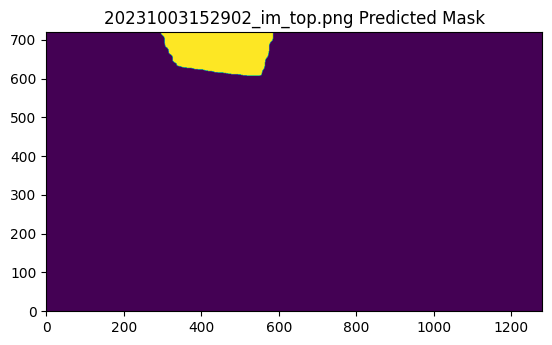

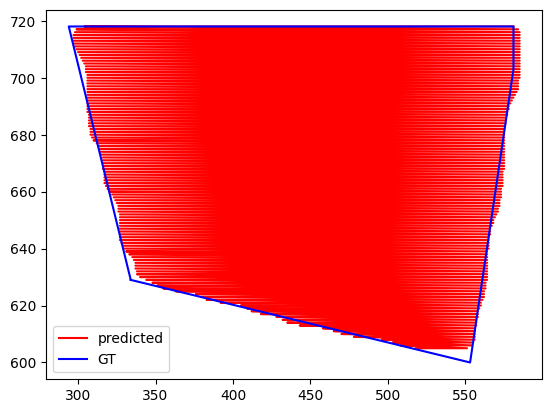

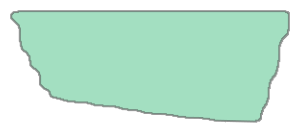

In [15]:
# visualize a sample of prediction mask
pred_sample = masks[7][0][1]
plt.title(f"{masks[7][1]} Predicted Mask")
plt.imshow(pred_sample)
# flip y
plt.gca().invert_yaxis()
plt.show()

# convert tensor to numpy array
pred_sample = pred_sample.numpy()
# find edge points of pred_sample
edge = np.zeros_like(pred_sample)
edge[1:,:] = edge[1:,:] | (pred_sample[1:,:] != pred_sample[:-1,:])
edge[:-1,:] = edge[:-1,:] | (pred_sample[1:,:] != pred_sample[:-1,:])
edge[:,1:] = edge[:,1:] | (pred_sample[:,1:] != pred_sample[:,:-1])
edge[:,:-1] = edge[:,:-1] | (pred_sample[:,1:] != pred_sample[:,:-1])
edge = edge * pred_sample
# extract x and y coordinates of the edge points
y_pred,x_pred = np.where(edge == 1)
edge = np.array(list(zip(x_pred, y_pred)))
plt.plot(edge[:,0], edge[:,1], "r", label="predicted")
plt.plot(x, y, "b", label="GT")
plt.legend()
plt.show()
pred_sample = Polygon(edge).buffer(1)
pred_sample


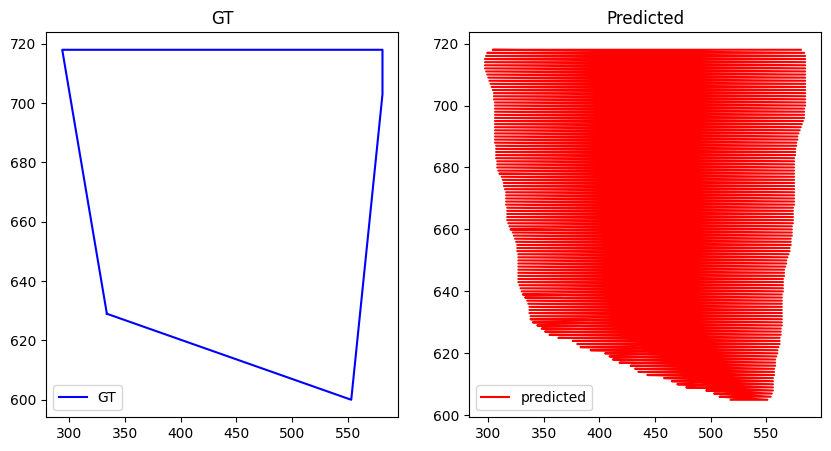

In [16]:
# display pred_sample and gt_sample
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, y, "b", label="GT")
ax[0].legend()
ax[0].set_title("GT")
ax[1].plot(edge[:,0], edge[:,1], "r", label="predicted")
ax[1].legend()
ax[1].set_title("Predicted")
plt.show()


In [17]:
# IoU of the sample masks
intersection = gt_sample.intersection(pred_sample)
union = gt_sample.union(pred_sample)
iou = intersection.area / union.area
iou

0.9644185146819947

## IoU & Confusion Matrix

In [18]:
def get_gt_polygon(idx):
    # image file name of the GT mask
    image_name = annotations["file_name"][idx]

    # category (class) ID of the GT mask
    gt_class = annotations["category_id"][idx]

    # # height and width of the image where the GT mask is from
    # h_sample, w_sample = annotations["height"][idx], annotations["width"][idx]

    # GT segmentation mask
    gt_seg = annotations["segmentation"]
    gt_mask = gt_seg[idx] # e.g., [[787, 317, 851, 315, 839, 366, 776, 372]]
    gt_mask = gt_mask[0] # remove the outer list

    # split the list into x and y coordinates (COCO format: x1, y1, x2, y2, ..., xn, yn)
    x = gt_mask[::2]
    y = gt_mask[1::2]

    # add the first point to the last point to close the polygon
    x.append(x[0])
    y.append(y[0])

    # convert x and y to [[x1,y1], [x2,y2], ..., [xn,yn]] format
    gt_mask = np.array(list(zip(x, y)))
    gt_mask = Polygon(gt_mask)
    return gt_class, gt_mask


In [19]:
def get_pred_polygon(image_idx, idx):
    # image file name of the predicted mask
    image_name = masks[image_idx][1]

    # predicted mask
    pred_mask = masks[image_idx][0][idx]

    # convert tensor to numpy array
    pred_mask = pred_mask.numpy()

    # find edge points of pred_sample
    edge = np.zeros_like(pred_mask)
    edge[1:,:] = edge[1:,:] | (pred_mask[1:,:] != pred_mask[:-1,:])
    edge[:-1,:] = edge[:-1,:] | (pred_mask[1:,:] != pred_mask[:-1,:])
    edge[:,1:] = edge[:,1:] | (pred_mask[:,1:] != pred_mask[:,:-1])
    edge[:,:-1] = edge[:,:-1] | (pred_mask[:,1:] != pred_mask[:,:-1])
    edge = edge * pred_mask

    # extract x and y coordinates of the edge points
    y,x = np.where(edge == 1)
    edge = np.array(list(zip(x, y)))
    pred_mask = Polygon(edge).buffer(1)

    return image_name, pred_mask


In [20]:
# compute IoUs
# reference: https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/
ious = []
tps_temp, fps_temp, fns_temp = [], [], []
tps, fps, fns = [], [], []
imgs = []
for i in tqdm(range(len(masks))): # for each image
    for j in range(masks[i][0].shape[0]): # for each mask in the image
        image_name_pred, pred_mask = get_pred_polygon(i, j)
        for k in range(len(annotations)): # compute IoU with all GT masks in the same image
            if annotations["file_name"][k] == image_name_pred: # if the image names match
                _, gt_mask = get_gt_polygon(k)
                intersection = gt_mask.intersection(pred_mask)
                union = gt_mask.union(pred_mask)
                tp = intersection.area
                fp = pred_mask.area - tp
                fn = gt_mask.area - tp
                iou = tp / (tp + fp + fn) # iou = intersection.area / union.area
                ious.append(iou)
                tps_temp.append(tp); fps_temp.append(fp); fns_temp.append(fn)
        # locate the index of the highest IoU
        idx = np.argmax(ious)
        tps.append(tps_temp[idx]) # TP of the maks of the highest IoU
        fps.append(fps_temp[idx]) # FP of the maks of the highest IoU
        fns.append(fns_temp[idx]) # FN of the maks of the highest IoU
        # reset temporary lists
        ious = []
        tps_temp, fps_temp, fns_temp = [], [], []
tps, fps, fns = np.array(tps), np.array(fps), np.array(fns)

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


In [50]:
# compute confusion matrix by area
confusion_matrix = np.zeros((2, 2))
confusion_matrix[0, 0] = np.sum(tps) # TP
confusion_matrix[0, 1] = np.sum(fns) # FN
confusion_matrix[1, 0] = np.sum(fps) # FP
confusion_matrix[1, 1] = 0
confusion_matrix = confusion_matrix.astype(int)
confusion_matrix

array([[7099662, 1495296],
       [1545145,       0]])

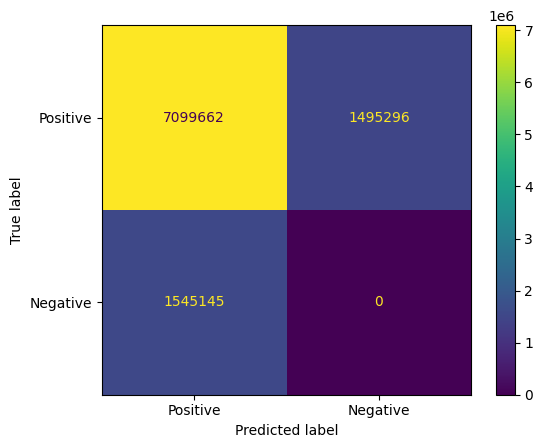

In [51]:
# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(values_format="d", cmap="viridis")
plt.show()

Recall=82.60%, Precision=82.13%, F-1 Score=82.36%, Accuracy=70.02%


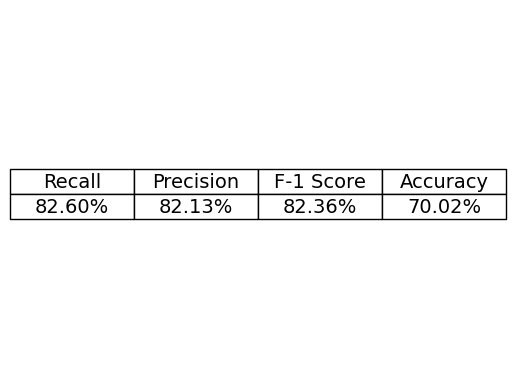

In [33]:
# compute recall, precision, and F-1 score
recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
f1 = 2 * precision * recall / (precision + recall)
acc = np.sum(tps) / (np.sum(tps) + np.sum(fps) + np.sum(fns))
recall, precision, f1, acc
print(f"Recall={recall*100:.2f}%, Precision={precision*100:.2f}%, F-1 Score={f1*100:.2f}%, Accuracy={acc*100:.2f}%")

# visualize it as a table figure using plt
fig, ax = plt.subplots()
ax.axis("off")
table = ax.table(cellText=[[f"{recall*100:.2f}%", f"{precision*100:.2f}%", f"{f1*100:.2f}%", f"{acc*100:.2f}%"]],
                colLabels=["Recall", "Precision", "F-1 Score", "Accuracy"],
                  cellLoc="center",
                  loc="center")
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 1.5)
plt.show()